In [6]:
%matplotlib inline

# London tube dataset originally provided by: markdunne (github.com/markdunne)
# Bike dataset provided by: Transport for London

# Modified by Josh Spicer <https://joshspicer.com/> and Tom Bain <https://twitter.com/tomhmbain/>

# Before running you may need to either supply data, or supply various API keys for the 
# program to fetch data itself.  Search for "<YOUR-TOKEN" for more info.

import colorsys
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
output_notebook( resources=CDN )
import warnings
import math
import requests
import json
import time

warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.set_option('max_colwidth', 200)

Loading BokehJS ...

In [7]:
#### Tube ####
lines       = pd.read_csv('data-sets/london-tube/london.lines.csv', index_col=0)
stations    = pd.read_csv('data-sets/london-tube/london.stations.csv', index_col=0)
stationsRein= pd.read_csv('data-sets/london-tube/london.stations.reindexed.csv', index_col=0)
connections = pd.read_csv('data-sets/london-tube/london.connections.csv')

#### Bikes ####
# http://cycling.data.tfl.gov.uk
bikeTripData = pd.read_csv('data-sets/bikes/london-bikes-sorted.csv', index_col=0)
# https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml
bikeDockingStations = pd.read_csv('data-sets/bikes/santander-cycle-coords.csv', index_col=0)  

#### Uber ####
uberTripData = pd.read_csv('data-sets/uber/compiledUberData.csv', index_col=0)  # Uber API



In [8]:
# Tube Graph

tubeGraph = nx.Graph()

for connection_id, connection in connections.iterrows():
    line_name = lines.ix[connection.line]['name']
    station1_name = stations.ix[connection.station1]['name']
    station2_name = stations.ix[connection.station2]['name']

    #Oxford Circus - Central Line
    node1_name = "%s - %s" % (station1_name, line_name)
    node2_name = "%s - %s" % (station2_name, line_name)
    
    #"Bond Street - Central Line" to "Oxford Circus - Central Line"
    tubeGraph.add_edge(node1_name, node2_name,    time = connection['time'])
    
    #"Oxford Circus - Central Line" to "Oxford Circus"
    tubeGraph.add_edge(node1_name, station1_name, time = 2)
    tubeGraph.add_edge(node2_name, station2_name, time = 2)
    
    #"Oxford Circus - Central Line" to "Oxford Circus - Victoria Line"
    for neighbor in tubeGraph.neighbors(station1_name):
        tubeGraph.add_edge(node1_name, neighbor, time = 5)        
    for neighbor in tubeGraph.neighbors(station2_name):
        tubeGraph.add_edge(node2_name, neighbor, time = 5)
        
tubeGraph.add_edge('Bank', 'Monument', time = 1)

In [9]:
# Example Shortest Path. Can easily calculate based on weighted times.

nx.shortest_path(tubeGraph, 'Oxford Circus', 'Canary Wharf', weight='time')

['Oxford Circus',
 'Oxford Circus - Victoria Line',
 'Green Park - Victoria Line',
 'Green Park',
 'Green Park - Jubilee Line',
 'Westminster - Jubilee Line',
 'Waterloo - Jubilee Line',
 'Southwark - Jubilee Line',
 'London Bridge - Jubilee Line',
 'Bermondsey - Jubilee Line',
 'Canada Water - Jubilee Line',
 'Canary Wharf - Jubilee Line',
 'Canary Wharf']

In [10]:
# You can do `graph things` on the graph.
nx.algorithms.connectivity.cuts.minimum_node_cut(tubeGraph)

{'Marylebone - Bakerloo Line'}

In [11]:
# Divide bike data into different files for quicker processing
# or rather, store indices of start/stop of data.
startOfBikeDataStartStationSection = {}
startOfBikeDataStartStationSection[1] = 0

currId = 1
for station_id, station in bikeTripData.iterrows():
    if currId == station["StartStation Id"]:
        continue
    else:
        startOfBikeDataStartStationSection[currId+1] = station_id
        currId = currId + 1
        

In [12]:
# Calculates the farthest bike station from the center.


def calcFarthestBikeStationFromCityCenter():
    maxDistance = 0
    maxStationName = ''
    maxStationId = -1

    # Center of London
    center = (51.510776, -0.115638)

    for id, station in bikeDockingStations.iterrows():
    
        Lat = station["station__lat"]
        Long = station["station__long"]
        Distance = math.sqrt((Lat*(11/7))**2 + (Long)**2)
    
        if Distance > maxDistance:
            maxStationName = station["station__name"]
            maxStationId = id
            maxDistance = Distance
        
    print("Furthest Docking Station:",maxStationName, " - ",maxStationId)
    print(bikeDockingStations.at[maxStationId,"station__lat"], bikeDockingStations.at[maxStationId,"station__long"])


In [13]:
###################### START OF THE COMPUTATION #####################

In [14]:
# ------------- Get Random value and Mean -----------------

def randomCoordinate():
    # Calcuates mean coordinates based on Tube Stations
    latcoors = stationsRein['latitude']
    longcoors = stationsRein['longitude']
    latmean = latcoors.mean()
    longmean = longcoors.mean()

    #meancoors = (latmean, longmean)
    meancoors = (51.510776, -0.115638) # Center of London
    # print("Mean Coordinates: ", meancoors)

    latitudeBoundSize = 0.03  # Mess with these for bigger radius
    longitudeBoundSize = 0.1  # Mess with these for bigger radius

    randLat1 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong1 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))
    randLat2 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong2 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))

    #print("Random origin location:        ", randLat1,"," ,randLong1)
    #print("Random destination location:   ", randLat2,",", randLong2)
    
    return randLat1, randLong1, randLat2, randLong2

In [15]:
def getRandomBikeTrip():
    
    randIdx = -1
    dataPotentiallyDangerous = True
    while (dataPotentiallyDangerous):
        # Get random index between 0 and size of bikeTripData
        randIdx = random.randint(0,len(bikeTripData))
        
        dataPotentiallyDangerous = False
        
        # Try it
        try:
            randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
            randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
            bikeDockingStations.at[int(randomStationId1), "station__lat"]
            bikeDockingStations.at[int(randomStationId2), "station__lat"]
    
        except Exception:
            dataPotentiallyDangerous = True
    
    # Choose a random bike trip
    randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
    randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
    randomTripDuration = int(bikeTripData.at[int(randIdx),"Duration"])
    
    # Get the latitude and longitude of a trip
    randLat1  =  bikeDockingStations.at[int(randomStationId1), "station__lat"]
    randLong1 =  bikeDockingStations.at[int(randomStationId1), "station__long"]
    randLat2  =  bikeDockingStations.at[int(randomStationId2), "station__lat"]
    randLong2 =  bikeDockingStations.at[int(randomStationId2), "station__long"]

      # DEBUG
      # print(randomStationId1)
      # print(randomStationId2)
      # print(randomTripDuration/60)
    
    # Calculate the distance in miles.
    coorDistance = math.sqrt((randLat1 - randLat2)**2 + ((randLong1 - randLong2)*(70/111))**2)*(68.9722)
    
    return randLat1, randLong1, randLat2, randLong2, randomStationId1, randomStationId2, coorDistance
    
# Demonstrate how this function works   
getRandomBikeTrip()
    

(51.518908, -0.079249, 51.52364804, -0.074754872, 251, 132, 0.3809132924295746)

In [16]:
# --------------- Calculates the closest TUBE stations to the random coordinates --------------

def closestTubeStation(randLat1, randLong1, randLat2, randLong2):
    #calculate distances to all stations in array from co-ordinates
    tubeDistances1 = []
    tubeDistances2 = []
    for i in range(1, len(stationsRein['longitude'])):
        distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
        distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

        tubeDistances1.append(distance1)
        tubeDistances2.append(distance2)

    #pick shortest for each co-ordinate
    station1 = tubeDistances1.index(min(tubeDistances1))
    station2 = tubeDistances2.index(min(tubeDistances2))
    
    oName = stationsRein['name'][station1+1]
    oLat  = stationsRein['latitude'][station1+1]
    oLong = stationsRein['longitude'][station1+1]
    
    dName = stationsRein['name'][station2+1]
    dLat  = stationsRein['latitude'][station2+1]
    dLong = stationsRein['longitude'][station2+1]

    #print("Nearest train station to Random Origin:",oName,oLat,oLong)
    #print("Nearest train station to Random Destination:",dName,dLat,dLong)
    
    return oName, dName
    #return oName,oLat,oLong,dName,dLat,dLong

In [17]:
# ---------------- Calculate the closest BIKE station to the random coordinates ---------------

def closestBikeStation(randLat1, randLong1, randLat2, randLong2):

    shortestOriginID = -1
    shortestDestID = -1
    
    shortestBikeOriginValue = 9999
    shortestBikeDestinationValue = 9999

    for st_id, dockingStation in bikeDockingStations.iterrows():
        dockingID = st_id
        dockingLat  = dockingStation["station__lat"]
        dockingLong = dockingStation["station__long"]
        distanceFromRandomToOrigin      = math.sqrt(((randLat1 - dockingLat)*11/7)**2 + (randLong1 - dockingLong)**2)
        distanceFromRandomToDestination = math.sqrt(((randLat2 - dockingLat)*11/7)**2 + (randLong2 - dockingLong)**2)

        if distanceFromRandomToOrigin < shortestBikeOriginValue:
            shortestOriginID = dockingID
            shortestBikeOriginValue = distanceFromRandomToOrigin

        if distanceFromRandomToDestination < shortestBikeDestinationValue:
            shortestDestID = dockingID
            shortestBikeDestinationValue = distanceFromRandomToDestination

    #print("Nearest bike station to Random Origin:", shortestOriginID)
    #print("Nearest bike station to Random Destination:", shortestDestID)
    
    return shortestOriginID, shortestDestID

In [18]:
# ------------- Calculate BIKE travel time -----------------------
# Calculates the mean of the closest bike ports, as well as ones that are really close.

def calcBikeTravelTimeMins(oBikeStationID, dBikeStationID):
    exactMatches = 0
    #relativeMatches = 0
    totalDurationAllTrips = 0
    
    # Get the range of samples to look at 
    # As an optimization, only looked at the subset of data with the curent station station.
    try:
        lowerBound = startOfBikeDataStartStationSection[oBikeStationID]
        upperBound = startOfBikeDataStartStationSection[oBikeStationID +1] - 1
    except Exception:
        return -1
    
    if lowerBound == 0:
        lowerBound = 1
    
    #print(oBikeStationID,lowerBound,upperBound)
    
    for i in range(lowerBound, upperBound):

        # Extract the trip data.
        tStartName =  bikeTripData.at[int(i),"StartStation Name"]
        tStartID =    bikeTripData.at[int(i),"StartStation Id"]

        tEndName   =  bikeTripData.at[int(i),"EndStation Name"]
        tEndID =  bikeTripData.at[int(i),"EndStation Id"]
        
        tDuration = bikeTripData.at[int(i),"Duration"]
        
        # If this trip exactly matches the given origin and dest.
        if oBikeStationID == tStartID and dBikeStationID == tEndID:
            exactMatches += 1
            totalDurationAllTrips += tDuration
            
            
    #print("For bikes there were:",exactMatches, "exact matches.")
    #print("For bikes there were:",relativeMatches, "relative matches.")
    
    if exactMatches == 0:
        return -1 # ERROR! No matches...
    
    bikeMins = (totalDurationAllTrips / (exactMatches))/60
    #print("The average time of this BIKE trip is:", bikeMins, "minutes.")
    
    
    return bikeMins

In [19]:
# --------------- Calculate TRAIN travel time --------------
# Calculates with dijkstra's shortest path algorithm (weighted by TIME)
def calcTrainTravelTimeMins(oName, dName):
    
    #nx.algorithms.shortest_paths.dijkstra_path(tubeGraph, oName, dName)

    quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time")

    #print("The quickest time for this TRAIN trip is ",quickestTrainTime, "minutes.")
    
    return quickestTrainTime

In [20]:
#### ------ Calculate how far the trip actually is------- ####

#distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
#distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

In [21]:
# Experiment: Bikes vs Trains

# ########## RUN ME ############
numIterations = 5000


# ##############################

mainTestOutput = {}
for i in range(0, numIterations):
    #print("[!] Iteration", i)
    
    # Compute coordinates in our range
    #(randLat1, randLong1, randLat2, randLong2) = randomCoordinate()
    (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()

    # Calculate the nearest origin and destination stations, given the random coordinates.
    (oTrain,dTrain) = closestTubeStation(randLat1, randLong1, randLat2, randLong2)
##    (oBike, dBike) = closestBikeStation(randLat1, randLong1, randLat2, randLong2)

    # Calculate the minimum/average travel time (with our data) given an origin and a destination.
    trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
    bikeMins = calcBikeTravelTimeMins(oBike, dBike)

    if bikeMins == -1 or trainMins == -1 or (oTrain == dTrain):
        #print("Skipping this one.")
        continue
        
    mainTestOutput[i] = {"oRandomLat": randLat1,
                 "oRandomLong": randLong1,
                 "dRandomLat": randLat2,
                 "dRandomLong": randLong2,
                 "coorDistance": coorDistance,
                 "oTrain": oTrain, 
                 "dTrain": dTrain,
                 "oBike": oBike,
                 "dBike": dBike,
                 "bikeMins": bikeMins,
                 "trainMins": trainMins}
    
mainTestOutputDF = pd.DataFrame.from_dict(mainTestOutput, orient="index")



In [22]:
# Save data to csv file.
# mainTestOutputDF.to_csv("./londonComputedData/computedData.csv")


(0, 8)

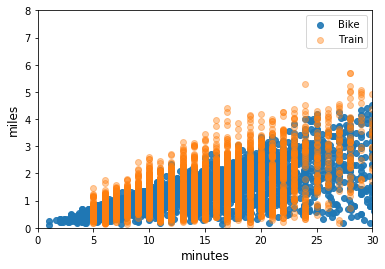

In [23]:
# Visualization
fig = plt.figure()
plt.scatter(x = mainTestOutputDF['bikeMins'],y = mainTestOutputDF['coorDistance'], alpha = 0.9)
plt.scatter(x = mainTestOutputDF['trainMins'],y = mainTestOutputDF['coorDistance'], alpha = 0.4)
# fig.suptitle('Travel Time per Mile', fontsize=20)
plt.xlabel('minutes', fontsize=12)
plt.ylabel('miles', fontsize=12)
plt.legend(["Bike","Train"])
# Remove outliers
plt.xlim(0,30)#minutes
plt.ylim(0,8) #miles

In [24]:
# Calculate the average distance where bike is faster than train
count = 0
bikeFasterCount = 0
for t_id, trip in mainTestOutputDF.iterrows():
    count += 1
    if trip["bikeMins"] < trip["trainMins"]:
        bikeFasterCount += 1
        
print(bikeFasterCount/count)
        

0.46774193548387094


In [25]:
#plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['bikeMins'], alpha = 0.1)
#plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['trainMins'], alpha = 0.1)

In [26]:
# quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time") + math.floor(nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph, oName, dName)/3)*3

In [27]:
# Determine which trips were faster riding a bike

def determineTripsFasterWithBike():
    tripsFasterWithBike = 0
    for t_id, trip in mainTestOutputDF.iterrows():
            if trip['trainMins'] > trip['bikeMins']:
                tripsFasterWithBike = tripsFasterWithBike + 1
                
    # print("There are:", tripsFasterWithBike, "Faster trips with a bike out of", len(mainTestOutputDF) ,"trips.")

In [33]:
#  Get the coordinates of lots of possible bike trips
#  Use this to compile the Uber data.
def computeSetOfCoords():
    setOfCoordinates = {}
    for i in range(0,100):
        (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
        setOfCoordinates[i] = {"randLat1":randLat1, "randLong1":randLong1, "randLat2":randLat2, "randLong2":randLong2, "oBike":oBike, "dBike":dBike, "coorDistance":coorDistance}

    setOfCoordinatesDF = pd.DataFrame.from_dict(setOfCoordinates, orient="index")
    setOfCoordinatesDF.to_csv("raw-data/uber/setOfCoordinates.csv")
    
    return setOfCoordinatesDF

#setOfCoordinatesDF

In [34]:
# Fetches equivalant trip data for uber rides by asking the Uber API directly.  
def askUberForInfo():
    
    uberResults = {}
    uberRawResults = {}
    # Supply several API tokens to "get around" rate-limiting.
    tokens = ["<YOUR-TOKEN-1>", "<YOUR-TOKEN-2>", "<...>",]
    idx = 0
    
    for token in tokens:
        setOfCoordinatesDF = computeSetOfCoords()
        for e_idx, element in setOfCoordinatesDF.iterrows():
            
            if (element["oBike"] == element["dBike"]):
                continue


            a = element['randLat1']
            b = element['randLong1']
            c = element['randLat2']
            d = element['randLong2']
            
            tokenStr = "Bearer " + token

            data = json.dumps({"start_latitude": a,"start_longitude": b,"end_latitude": c,"end_longitude": d})
            headers = {'Content-Type': 'application/json', 'Authorization': tokenStr}
            r = requests.post('https://api.uber.com/v1.2/requests/estimate', headers=headers, data=data)

            response = r.json()
            #print(r.status_code, "for #", idx)

            if (r.status_code != 200):
                #print("Encountered Error with API on iteration", idx)
                #print(response)
                break

            rawUberTripTime = response["trip"]["duration_estimate"]
            uberTripDistance = response["trip"]["distance_estimate"]
            uberTripValue = response['estimate']['display']
            pickupEstimate = response['pickup_estimate']

            
            
            # Increment Global index
            idx = idx + 1

            uberResults[idx] = {"originBikeStation": int(element["oBike"]), 
                                  "destBikeStation": int(element["dBike"]), 
                                  "rawUberTripTime":rawUberTripTime,
                                  "pickupEstimate": pickupEstimate, 
                                  "uberTripDistance": uberTripDistance, 
                                  "uberTripValue": uberTripValue,
                                  "uberTripTime": rawUberTripTime + (pickupEstimate*60)}

            uberRawResults[idx] = response

        uberResultsDF = pd.DataFrame.from_dict(uberResults, orient="index")
        rawUberResultsDF = pd.DataFrame.from_dict(uberRawResults, orient="index")
        timeStamp = int(time.time())
        uberResultsDF.to_csv("raw-data/uber/uberResults" + str(timeStamp) + ".csv")
        rawUberResultsDF.to_csv("raw-data/uber/uberRawResults" + str(timeStamp) + ".csv")

    return uberResultsDF, rawUberResultsDF



In [35]:
# RUNS API SCRIPT
# Generate a set of coordinates that is a valid trips on bikes
# Calculate an equivalant trip with Uber by asking Uber's API.  (Gets the price and travel time)

uberResultsDF, rawUberResultsDF = askUberForInfo()



In [36]:
########## MAIN EXPERIMENT WITH UBER #######
# Iterates through uber trip data, 
# using the stored origin station and destination to calculate bike and train trips.

mainTestOutputWithUber = {}


for u_id, uberTrip in uberTripData.iterrows(): ### RUNNING ON A PRE-MADE DATASET LOADED IN THE BEGINNING
    #print("[!] Iteration", u_id)

    # (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
    oBike = uberTrip['originBikeStation']
    dBike = uberTrip['destBikeStation']
    
    uberTripTime = uberTrip['uberTripTime']
    uberTripDistance = uberTrip['uberTripDistance']
    uberTripValue = uberTrip['uberTripValue']
    
    originLat  =  bikeDockingStations.at[oBike, "station__lat"]
    originLong =  bikeDockingStations.at[oBike, "station__long"]
    destLat  =    bikeDockingStations.at[dBike, "station__lat"]
    destLong =    bikeDockingStations.at[dBike, "station__long"]
    
    # Calculate the nearest origin and destination stations, given the random coordinates.
    (oTrain,dTrain) = closestTubeStation(originLat, originLong, destLat, destLong)

    # Calculate the minimum/average travel time (with our data) given an origin and a destination.
    trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
    bikeMins = calcBikeTravelTimeMins(oBike, dBike)

    if bikeMins == -1 or trainMins == -1 or (oTrain == dTrain):
        #print("Skipping this one...")
        continue
    
    uberMins = 0
    if uberTripTime > 0:
        uberMins = uberTripTime / 60    
        
    mainTestOutputWithUber[u_id] = {
        "oLat": originLat,
        "oLong": originLong,
        "dLat": destLat,
        "dLong": destLong,
        "uberTripDistance": uberTripDistance,
        "uberTripValue": uberTripValue,
        "oTrain": oTrain, 
        "dTrain": dTrain,
        "oBike": oBike,
        "dBike": dBike,
        "bikeMins": bikeMins,
        "trainMins": trainMins,
        "uberMins": uberMins}
    
mainTestOutputWithUberDF = pd.DataFrame.from_dict(mainTestOutputWithUber, orient="index")

In [37]:
# Dataframe of output dataset
## mainTestOutputWithUberDF

(0, 3)

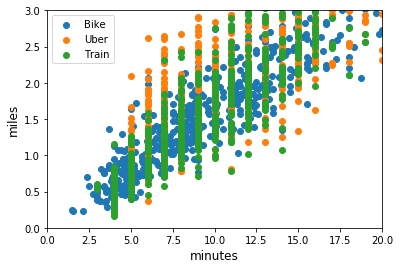

In [38]:
# Plot the trip distances (miles) vs. time (all three modes)

bikeMinsArr = []
uberMinsArr = []
trainMinsArr = []

bikeMinsDist = []
uberMinsDist = []
trainMinsDist = []


def getMinimum(entry_mt):
    bikeMins = entry_mt['bikeMins']
    uberMins = entry_mt['uberMins']
    trainMins = entry_mt['trainMins']
    minNum = np.argmin([bikeMins,trainMins,uberMins])
    if minNum == 0:
        return (0,bikeMins)
    if minNum == 1:
        return (1,trainMins)
    if minNum == 2:
        return (2,uberMins)


for idx_mt, entry_mt in mainTestOutputWithUberDF.iterrows():
    minNum = getMinimum(entry_mt)[0]
    minNumValue = getMinimum(entry_mt)[1]
    if minNum == 0:
        bikeMinsArr.append(minNumValue)
        bikeMinsDist.append(entry_mt["uberTripDistance"])
    if minNum == 1:
        uberMinsArr.append(minNumValue)
        uberMinsDist.append(entry_mt["uberTripDistance"])
    if minNum == 2:
        trainMinsArr.append(minNumValue)
        trainMinsDist.append(entry_mt["uberTripDistance"])

    
# print(bikeMinsDist)
    
plt.scatter(x = bikeMinsArr,y = bikeMinsDist)
plt.scatter(x = uberMinsArr,y = uberMinsDist)
plt.scatter(x = trainMinsArr,y = trainMinsDist)


# plt.scatter(x = mainTestOutputWithUberDF['uberMins'],y = mainTestOutputWithUberDF['uberTripDistance'], alpha = 0.4)
# plt.plot(x = mainTestOutputWithUberDF['trainMins'],y = mainTestOutputWithUberDF['uberTripDistance'], alpha = 0.4)
# fig.suptitle('Travel Time per Mile', fontsize=20)
plt.xlabel('minutes', fontsize=12)
plt.ylabel('miles', fontsize=12)
plt.legend(["Bike","Uber","Train"])
# Remove outliers
plt.xlim(0,20)#minutes
plt.ylim(0,3) #miles



In [39]:
bikeGraph = nx.Graph()

# Add in all the bike docking station nodes.
for s_id, dockingStation in bikeDockingStations.iterrows():
    
     
    # center of city lat,long
    # originLatLong
    #
    # Can draw it to see!
    #    coorDistance = math.sqrt((randLat1 - randLat2)**2 + ((randLong1 - randLong2)*(70/111))**2)*(68.9722)
    
    center = (51.510776, -0.115638) # Center of London

    distToCenterMiles = math.sqrt((center[0] - dockingStation["station__lat"])**2 
                                + ((center[1] - dockingStation["station__long"])*(70/111))**2)*(68.9722)
    

    bikeGraph.add_node(s_id, 
                        coordinates=(dockingStation["station__lat"],
                                     dockingStation["station__long"]), 
                        distToCenter=distToCenterMiles,
                        name=dockingStation['station__name'])


        
for t_id, trip in mainTestOutputWithUberDF.iterrows():
    bikeGraph.add_edge(trip["oBike"], 
                       trip["dBike"], 
                       weight=trip['uberTripDistance'],
                       bikeMins=trip['bikeMins'], 
                       trainMins=trip['trainMins'], 
                       uberMins=trip['uberMins'])
    
    
    
    
#     startLocation = trip['oBike']
#     endLocation = trip['dBike']
#     bikeUberGraph.add_node(1, time='5pm')#     tubeGraph.add_edge(startLocation, endLocation)

In [40]:
# This block draws three identical graphs, 
# but for each one only draws the edge if it's the 
# quickest route for that mode of transport (bike, train, uber)

####################### Experiment Variables ##############################
minDist = 0
maxDist = 10         #set to 0,10 to ignore

minCenterDist = 0.5
maxCenterDist = 1   #set to 0,10 to ignore
###########################################################################

bNum = 0
gNum = 0
oNum = 0


def minTimeModeOfTransportColor(edge):
    bikeMins = bikeGraph[edge[0]][edge[1]]['bikeMins'] #0 - Blue
    trainMins = bikeGraph[edge[0]][edge[1]]['trainMins'] #1 - Green
    uberMins = bikeGraph[edge[0]][edge[1]]['uberMins'] #2 - Orange
    minNum = np.argmin([bikeMins,trainMins,uberMins])
    if minNum == 0:
        return "blue"
    if minNum == 1:
        return "green"
    if minNum == 2:
        return "orange"
    


    
# nx.draw(bikeGraph, nx.get_node_attributes(bikeGraph, 'coordinates'), with_labels=False)


normalize = bikeDockingStations[['station__lat', 'station__long']]
normalize = normalize - normalize.min()
normalize = normalize / normalize.max()+1

locations = dict(zip(bikeDockingStations.index, normalize[['station__lat', 'station__long']].values))

# b = figure(
#     x_range = (-0.1,1.5),
#     y_range = (-0.5,1.5),
#     height= 1000,
#     width= 1000,
# )

# g = figure(
#     x_range = (-0.1,1.5),
#     y_range = (-0.5,1.5),
#     height= 1000,
#     width= 1000,
# )

# o = figure(
#     x_range = (-0.1,1.5),
#     y_range = (-0.5,1.5),
#     height= 1000,
#     width= 1000,
# )

master = figure(
    x_range = (-0.1,1.5),
    y_range = (-0.5,1.5),
    height= 1000,
    width= 1000,
)

for edge in bikeGraph.edges():
    
    routeColor = minTimeModeOfTransportColor(edge)
    
    #Only plot for certain ranges of total distances traveled
    if bikeGraph[edge[0]][edge[1]]['weight'] < minDist or bikeGraph[edge[0]][edge[1]]['weight'] > maxDist:
        continue
        
    #### TODO: Only if origin/destination are in some travel band from city center
    distToTheCenterOrigin = bikeGraph.node[edge[0]]['distToCenter']
    distToTheCenterDest = bikeGraph.node[edge[1]]['distToCenter']

    #Only if it's within the appropriate band of the city center
    if (distToTheCenterOrigin < minCenterDist) or (distToTheCenterOrigin > maxCenterDist) or (distToTheCenterDest < minCenterDist) or (distToTheCenterDest > maxCenterDist):
        continue
    
        
    master.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
        color=routeColor,
        )
    
    if routeColor == 'blue':
        bNum += 1
    elif routeColor == 'green':
        gNum += 1
    else:
        oNum +=1
    

#     if minTimeModeOfTransportColor(edge) == 'blue':
#         b.line( 
#             x= [locations[pt][0] for pt in edge],
#             y= [locations[pt][1] for pt in edge],
#             color='blue',
#         )
#     elif minTimeModeOfTransportColor(edge) == 'orange':
#         o.line( 
#             x= [locations[pt][0] for pt in edge],
#             y= [locations[pt][1] for pt in edge],
#             color="orange",
#         )
#     else:
#         g.line( 
#             x= [locations[pt][0] for pt in edge],
#             y= [locations[pt][1] for pt in edge],
#             color="green",
#         )
 
    
for node in bikeGraph.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    
    distToTheCenter = bikeGraph.node[node]['distToCenter']
    #Only if it's within the appropriate band of the city center
    if distToTheCenter < minCenterDist or distToTheCenter > maxCenterDist:
        continue
    
    
    master.circle(
        x, y, 
        radius = 0.003, 
        fill_color = "gray", 
        line_alpha=0)

    master.text(
        x, y, 
        text = {'value':str(node)}, 
        text_font_size = str(5) + "pt", 
        text_alpha = 1,
        text_align='center',
        text_font_style='bold')
    
    
    
#     b.circle(
#         x, y, 
#         radius = 0.003, 
#         fill_color = "gray", 
#         line_alpha=0)

#     b.text(
#         x, y, 
#         text = {'value':str(node)}, 
#         text_font_size = str(5) + "pt", 
#         text_alpha = 1,
#         text_align='center',
#         text_font_style='bold')
#     ###########################
#     o.circle(
#         x, y, 
#         radius = 0.003, 
#         fill_color = "gray", 
#         line_alpha=0)

#     o.text(
#         x, y, 
#         text = {'value':str(node)}, 
#         text_font_size = str(5) + "pt", 
#         text_alpha = 1,
#         text_align='center',
#         text_font_style='bold')
#     ##############################
#     g.circle(
#         x, y, 
#         radius = 0.003, 
#         fill_color = "gray", 
#         line_alpha=0)

#     g.text(
#         x, y, 
#         text = {'value':str(node)}, 
#         text_font_size = str(5) + "pt", 
#         text_alpha = 1,
#         text_align='center',
#         text_font_style='bold')
        
        
#Plot city center
master.circle(
    1.6,
    1.51, 
    radius = 0.003, 
    fill_color = "yellow",         
    line_alpha=0)

# b.savefig("bike-"+str(minDist)+"-"+str(maxDist)+".png")
#show(b) #BIKE

# o.savefig("uber-"+str(minDist)+"-"+str(maxDist)+".png")
#show(o) #UBER

# g.savefig("train-"+str(minDist)+"-"+str(maxDist)+".png")
#show(g) #TRAINS

# plt.savefig("master-"+str(minDist)+"-"+str(maxDist)+".png")
show(master)

print("range",minDist,maxDist)
print("proximityToCenter",minCenterDist,maxCenterDist)
print("Bike total", bNum)
print("Uber total", oNum)
print("Train total", gNum)

# Tip: Drag view slightly to the top-right corner to see the output of this specific experiement
# Tweak the values above to continue testing with different parameters



range 0 10
proximityToCenter 0.5 1
Bike total 22
Uber total 9
Train total 11


In [41]:
 #print(nx.clustering(bikeGraph))

In [42]:
# Results of tweaking values for the final experiment can be found in this git repo's APPENDIX pdf file.
# More information can be found in the README.